# Handball model replica

In this notebook we focus on replicating the work from [Groll et al. (2020)](https://content.iospress.com/articles/journal-of-sports-analytics/jsa200384) and compare how the model would perform with SEL features.

In [1]:
import os
import pyreadr
from sklearn.linear_model import LassoCV, ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np

import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session

from sklearn.preprocessing import MinMaxScaler

tfd = tfp.distributions

2023-06-02 17:51:36.746757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 17:51:37.326572: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-02 17:51:37.411517: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-02 17:51:37.411539: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
df = pyreadr.read_r('Daten.rda')['daten']

We prepare the data and split into training, validation and test sets.

In [4]:
train, test = train_test_split(df)
train.reset_index(drop=True, inplace=True)

sel_df = train.groupby('Team')[['Goals']].mean().rename(columns={'Goals': 'SEL'}).reset_index()

train = train.merge(sel_df, on='Team')

train, val = train_test_split(train)

test = test.merge(sel_df, on='Team')

Let us now define the features to use.

In [5]:
target = 'Goals'
cols = ['Age', 'Height', 'ihf.points', 'Rank', 'Trainer.age', 'Trainer.tenure', 'Legionairs', 'CL.final4', 'EHF.final4']
cols += ['max.teammates', 'sec.max.teammates', 'GDP', 'Odds', 'Population', 'Host', 'Host.oppo', 'Trainer.nat']
cols += ['Trainer.nat.oppo', 'Continent', 'Continent.oppo', 'Confed', 'Confed.oppo']
sel_cols = ['SEL']

In [6]:
perf = {}

## Elastic Net

We first start with an ElasticNet to replicate the LASSO model from Groll et al. and compare the regular features vs SEL.

In [7]:
regCV = ElasticNetCV(cv=10, alphas=[1], l1_ratio=np.arange(0.5, 1, 0.01)).fit(train[cols], train[target])

In [9]:
en = ElasticNet(l1_ratio=regCV.l1_ratio_).fit(train[cols], train[target])

Y_test_home_pred = en.predict(test[cols])
Y_train_home_pred = en.predict(train[cols])

train_perf_en = mean_squared_error(train[target], Y_train_home_pred, squared=False)
test_perf_en = mean_squared_error(test[target], Y_test_home_pred, squared=False)

perf.update({('Elastic Net', 'Vanilla'): [train_perf_en, test_perf_en]})

We do the same with the SEL feature and store the results/performance on our dictionary.

In [10]:
en = ElasticNet(l1_ratio=regCV.l1_ratio_).fit(train[cols + sel_cols], train[target])

Y_test_home_pred = en.predict(test[cols + sel_cols])
Y_train_home_pred = en.predict(train[cols + sel_cols])

train_perf_en_sel = mean_squared_error(train[target], Y_train_home_pred, squared=False)
test_perf_en_sel = mean_squared_error(test[target], Y_test_home_pred, squared=False)

perf.update({('Elastic Net', 'SEL'): [train_perf_en_sel, test_perf_en_sel]})

## Random Forest

In [11]:
rf_home = RandomForestRegressor(max_features=5, n_estimators=500, n_jobs=-1)
fitted_home = rf_home.fit(train[cols], train[target])
Y_test_home_pred = fitted_home.predict(test[cols])
Y_train_home_pred = fitted_home.predict(train[cols])

train_perf_rf = mean_squared_error(train[target], Y_train_home_pred, squared=False)
test_perf_rf = mean_squared_error(test[target], Y_test_home_pred, squared=False)

perf.update({('Random Forest', 'Vanilla'): [train_perf_rf, test_perf_rf]})

Add the SEL features and retrain.

In [12]:
rf_sel = RandomForestRegressor(max_features=5, n_estimators=500, n_jobs=-1)
fitted_sel = rf_sel.fit(train[cols + sel_cols], train[target])
Y_test_home_pred = fitted_sel.predict(test[cols + sel_cols])
Y_train_home_pred = fitted_sel.predict(train[cols + sel_cols])

train_perf_rf_sel = mean_squared_error(train[target], Y_train_home_pred, squared=False)
test_perf_rf_sel = mean_squared_error(test[target], Y_test_home_pred, squared=False)

perf.update({('Random Forest', 'SEL'): [train_perf_rf_sel, test_perf_rf_sel]})

## XGBoost

In [13]:
from xgboost import XGBClassifier, XGBRegressor

In [14]:
params = {
    'n_estimators': 500,
    'max_depth': 5,
    'learning_rate': 0.05,
    'objective': 'reg:squarederror',
}

In [15]:
xgb = XGBRegressor(**params)
fitted_xgb = xgb.fit(train[cols], train[target], verbose=0)

Y_train_home_pred = fitted_xgb.predict(train[cols])
Y_test_home_pred = fitted_xgb.predict(test[cols])

train_perf_xgb = mean_squared_error(train[target], Y_train_home_pred, squared=False)
test_perf_xgb = mean_squared_error(test[target], Y_test_home_pred, squared=False)

perf.update({('XGBoost', 'Vanilla'): [train_perf_xgb, test_perf_xgb]})

And with the SEL feature.

In [16]:
xgb_sel = XGBRegressor(**params)
fitted_xgb_sel = xgb_sel.fit(train[cols + sel_cols], train[target], verbose=0)

Y_train_home_pred = fitted_xgb_sel.predict(train[cols + sel_cols])
Y_test_home_pred = fitted_xgb_sel.predict(test[cols + sel_cols])

train_perf_xgb = mean_squared_error(train[target], Y_train_home_pred, squared=False)
test_perf_xgb = mean_squared_error(test[target], Y_test_home_pred, squared=False)

perf.update({('XGBoost', 'SEL'): [train_perf_xgb, test_perf_xgb]})

## Neural Net

In [17]:
def get_ann(data):
    inputs = Input(shape=(data.shape[1],))
    x = Dense(100, "relu")(inputs)
    x = Dense(100, "relu")(x)
    # x = Dense(25, "relu")(x)
    o = Dense(1)(x)

    p_y = tfp.layers.DistributionLambda(lambda x : tfd.Poisson(x))(x)
    model_p = Model(inputs=inputs, outputs=o)

    def NLL(y_true, y_hat):
        return -y_hat.log_prob(y_true)

    model_p.compile(loss="mse", optimizer=Adam(2e-4))

    early_stopping = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    return model_p, early_stopping

In [18]:
scaler = MinMaxScaler()
train[cols + sel_cols] = scaler.fit_transform(train[cols + sel_cols])
val[cols + sel_cols] = scaler.transform(val[cols + sel_cols])
test[cols + sel_cols] = scaler.transform(test[cols + sel_cols])

In [19]:
clear_session()
ann_vanilla_home, early_stop = get_ann(train[cols])

ann_vanilla_home.fit(train[cols], train[target], validation_data=(val[cols], val[target]), callbacks=[early_stop], epochs=500)

2023-06-02 17:51:57.945751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-02 17:51:57.946210: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-02 17:51:57.946609: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-06-02 17:51:57.947295: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-06-02 17:51:57.947559: W tensorf

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Epoch 1/500
12/12 [==============================] - 2s 36ms/step - loss: 765.7242 - val_loss: 789.4285
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 751.0711 - val_loss: 774.1945
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 736.1495 - val_loss: 758.1291
Epoch 4/500
12/12 [==============================] - 0s 9ms/step - loss: 719.8657 - val_loss: 739.6384
Epoch 5/500
12/12 [==============================] - 0s 10ms/step - loss: 700.7057 - val_loss: 717.3241
Epoch 6/500
12/12 [==============================] - 0s 9ms/step - loss: 677.4205 - val_loss: 690.1443
Epoch 7/500
12/12 [==============================] - 0s 8ms/step - loss: 649.0551 - val_loss: 656.3930
Epoch 8/500
12/12 [============

In [20]:
Y_train_home_pred = [p[0] for p in ann_vanilla_home.predict(train[cols])]
Y_test_home_pred = [p[0] for p in ann_vanilla_home.predict(test[cols])]

train_perf_ann = mean_squared_error(train[target], Y_train_home_pred, squared=False)
test_perf_ann = mean_squared_error(test[target], Y_test_home_pred, squared=False)

perf.update({('Neural Net', 'Vanilla'): [train_perf_ann, test_perf_ann]})

6/6 [==============================] - 0s 5ms/step


Now with the SEL feature.

In [21]:
clear_session()
ann_sel_home, early_stop = get_ann(train[cols + sel_cols])

ann_sel_home.fit(train[cols + sel_cols], train[target], validation_data=(val[cols + sel_cols], val[target]), callbacks=[early_stop], epochs=500)

Epoch 1/500
12/12 [==============================] - 2s 37ms/step - loss: 791.6738 - val_loss: 813.3995
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 772.9883 - val_loss: 793.6886
Epoch 3/500
12/12 [==============================] - 0s 8ms/step - loss: 753.8205 - val_loss: 773.2237
Epoch 4/500
12/12 [==============================] - 0s 10ms/step - loss: 733.2905 - val_loss: 750.2533
Epoch 5/500
12/12 [==============================] - 0s 8ms/step - loss: 709.7154 - val_loss: 722.9420
Epoch 6/500
12/12 [==============================] - 0s 9ms/step - loss: 681.4732 - val_loss: 690.0698
Epoch 7/500
12/12 [==============================] - 0s 11ms/step - loss: 647.5329 - val_loss: 650.9797
Epoch 8/500
12/12 [==============================] - 0s 8ms/step - loss: 607.5433 - val_loss: 605.0101
Epoch 9/500
12/12 [==============================] - 0s 7ms/step - loss: 560.9029 - val_loss: 551.9747
Epoch 10/500
12/12 [==============================] - 0s 10ms/step - l

In [22]:
Y_train_home_pred = [p[0] for p in ann_sel_home.predict(train[cols + sel_cols])]
Y_test_home_pred = [p[0] for p in ann_sel_home.predict(test[cols + sel_cols])]

train_perf_ann_sel = mean_squared_error(train[target], Y_train_home_pred, squared=False)
test_perf_ann_sel = mean_squared_error(test[target], Y_test_home_pred, squared=False)

perf.update({('Neural Net', 'SEL'): [train_perf_ann_sel, test_perf_ann_sel]})

6/6 [==============================] - 0s 3ms/step


## Models comparison

Let us now report and display the above models' performance.

In [23]:
perf_df = pd.DataFrame(perf).T.sort_index(ascending=False)
perf_df.columns = pd.MultiIndex.from_tuples([('RMSE', 'Train'), ('RMSE', 'Test')])
perf_df

RMSE          
                          Train      Test
XGBoost       Vanilla  0.243759  4.788710
              SEL      0.275120  4.805570
Random Forest Vanilla  1.752445  4.341268
              SEL      1.693789  4.271923
Neural Net    Vanilla  4.454564  4.551962
              SEL      4.253786  4.427057
Elastic Net   Vanilla  4.762501  4.495885
              SEL      4.487898  4.379905

## Features of importance

We can also analyze the features of importance from the Random Forest and XGBoost models to see how important our SEL features is.

<AxesSubplot: >

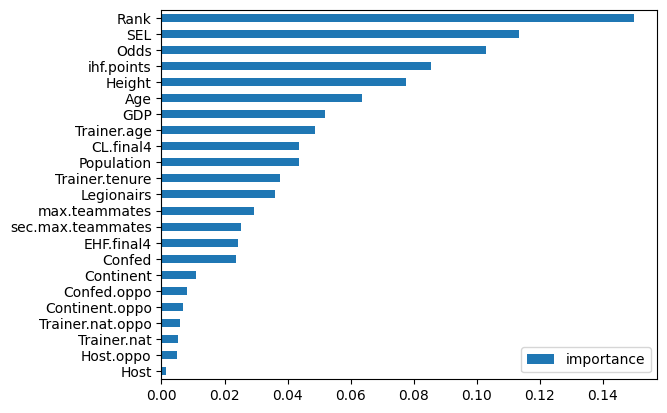

In [26]:
df = pd.DataFrame({'importance': rf_sel.feature_importances_}, index=cols + sel_cols).sort_values(by='importance')
df.to_csv("HandFeatImport.csv", index=True)
df.plot.barh()

<AxesSubplot: >

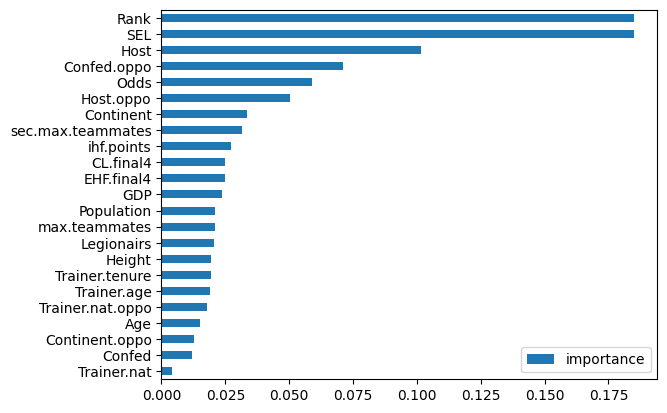

In [25]:
pd.DataFrame({'importance': xgb_sel.feature_importances_}, index=cols + sel_cols).sort_values(by='importance').plot.barh()